In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')


In [2]:
DIR = 'C:\\Users\\somfl\\Documents\\GitHub\\CreditDefaultPrediction\\DataFiles'
filename = os.path.join(DIR, 'default of credit card clients.csv') 


In [3]:
df = pd.read_csv(filename)

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,dpnm
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


LIMIT_BAL: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

SEX: (1 = male; 2 = female).

EDUCATION: (1 = graduate school; 2 = university; 3 = high school; 0, 4, 5, 6 = others).

MARRIAGE: Marital status (1 = married; 2 = single; 3 = divorce; 0=others).

AGE: Age (year).

PAY_1 to PAY_6: History of past payment, from April(PAY_6) to September(PAY_1) 2005 and is as follows: (-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.)

BILL_AMT1 to BILL_AMT6: Amount of bill statement (dollar) from April (BILL_AMT6) to Setember(BILL_AMT1) 2005.

PAY_AMT1 to PAY_AMT6: Amount of previous payment (dollar) from April (PAY_AMT6) to Setember(PAY_AMT1) 2005.

dpnm: (0: Fully Paid, 1: default")

In [5]:
df.shape

(30000, 25)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_1      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

In [7]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,dpnm
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## Check missing data

In [8]:
df.isnull().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dpnm         0
dtype: int64

## Check Duplicate

In [9]:
df.drop('ID', axis=1, inplace=True)

In [10]:
df.duplicated().sum()

35

In [11]:
## Drop duplicates
df.drop_duplicates(inplace=True)

## Correlation 

The following heatmap shows the correlation between all the features in the dataset. Of notable correlations (all positive) are "BILL_AMT" features with one another, then "PAY" features with eachother, respectively. It means that, in general, whether bill payments will be done on time or will have delays are somewhat correlated, but the bill statements are very correlated with eachother. This can be an issue when using models such as Logistic Linear Regression, but not so much for Decision Tree or Random Forest classifiers.

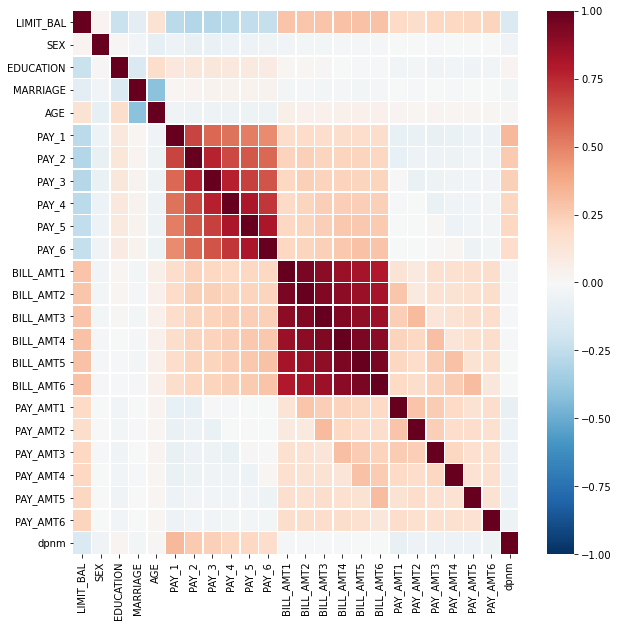

In [71]:
plt.figure(figsize = (10,10))
sns.heatmap(df.select_dtypes(np.number).corr() ,xticklabels=df.select_dtypes(np.number).corr().columns, yticklabels=df.select_dtypes(np.number).corr().columns, annot=False, cmap="RdBu_r",linewidths=.6,vmin=-1, vmax=1);


## Target prediction: dpnm

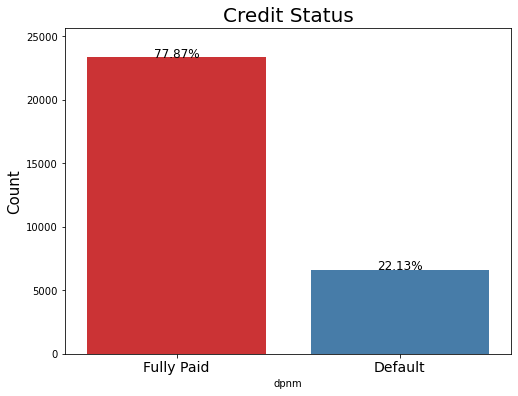

In [14]:
plt.figure(figsize = (8,6))

ax = sns.countplot(x="dpnm", data=df, palette="Set1")
# ax.set_xticklabels(ax.get_xticklabels(),rotation=0, fontsize=14)
ax.set_xticklabels(['Fully Paid', 'Default'],rotation=0, fontsize=14)

total = len(df)

ax.set_ylabel("Count", fontsize=15)
ax.set_title("Credit Status", fontsize=20)
sizes=[]
for p in ax.patches:
    height = p.get_height()
    sizes.append(height)
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
ax.set_ylim(0, max(sizes) * 1.10)

plt.show()

## Sex, Education, Marital Status

Gender (1 = male; 2 = female).

Education (1 = graduate school; 2 = university; 3 = high school; 0, 4, 5, 6 = others).

Marital status (1 = married; 2 = single; 3 = divorce; 0=others).

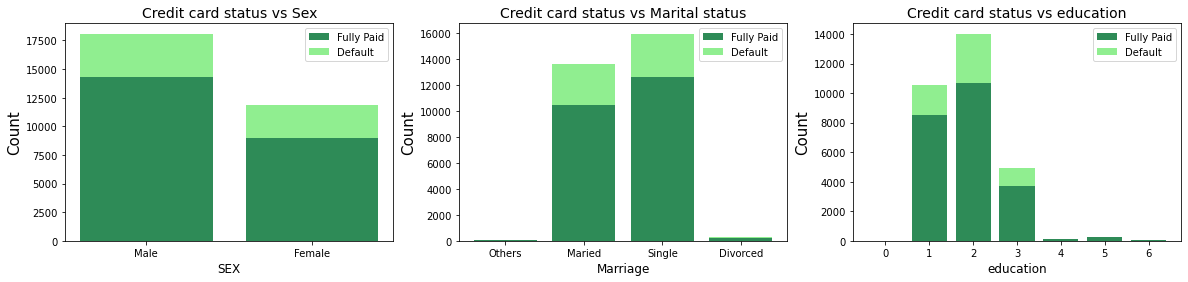

In [59]:
fig, [axes0, axes1, axes2] = plt.subplots(nrows = 1, ncols = 3, figsize=(20,4))

s1 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'SEX'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'SEX'].value_counts()}, index=None)
s2 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'MARRIAGE'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'MARRIAGE'].value_counts()}, index=None)
s3 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'EDUCATION'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'EDUCATION'].value_counts()}, index=None)

s1.index = ['Male', 'Female']
s2 = s2.reindex([0, 1, 2, 3])
s2.index = ['Others', 'Maried', 'Single', 'Divorced']
s3 = s3.reindex([0, 1, 2, 3, 4, 5, 6])
s3.index = ['0', '1', '2', '3', '4', '5', '6']

axes0.bar(s1.index, s1['Fully Paid'], color='seagreen')
axes0.bar(s1.index, s1['Default'], bottom=s1['Fully Paid'], color='lightgreen')
#axes0.set_xticklabels(s1.index, rotation=45)
axes0.set_xticklabels(['Male', 'Female'], rotation=0)
axes0.legend(['Fully Paid', 'Default'])
axes0.set_xlabel('SEX', fontsize=12)
axes0.set_ylabel('Count', fontsize=15)
axes0.set_title("Credit card status vs Sex", fontsize=14)


axes1.bar(s2.index, s2['Fully Paid'], color='seagreen')
axes1.bar(s2.index, s2['Default'], bottom=s2['Fully Paid'], color='lightgreen')
axes1.set_xticklabels(s2.index, rotation=0)
axes1.legend(['Fully Paid', 'Default'])
axes1.set_xlabel('Marriage', fontsize=12)
axes1.set_ylabel('Count', fontsize=15)
axes1.set_title("Credit card status vs Marital status", fontsize=14)

axes2.bar(s3.index, s3['Fully Paid'], color='seagreen')
axes2.bar(s3.index, s3['Default'], bottom=s3['Fully Paid'], color='lightgreen')
axes2.set_xticklabels(s3.index, rotation=0)
axes2.legend(['Fully Paid', 'Default'])
axes2.set_xlabel('education', fontsize=12)
axes2.set_ylabel('Count', fontsize=15)
axes2.set_title("Credit card status vs education", fontsize=14)


plt.show()

## AGE

No handles with labels found to put in legend.


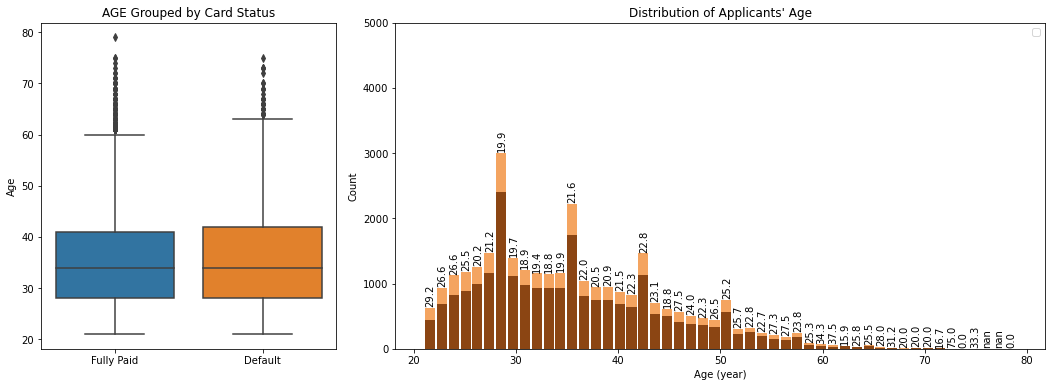

In [84]:
fig = plt.figure(figsize = (18,6))
ax1 = plt.subplot2grid((1,3),(0,0))
ax2 = plt.subplot2grid((1,3),(0,1), colspan=2)

sns.boxplot(y="AGE", x="dpnm", data=df, ax = ax1)
ax1.set_xlabel('')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['Fully Paid','Default'], ha='center')
ax1.set_title('AGE Grouped by Card Status')
ax1.set_ylabel('Age')

s1 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'AGE'], 'Default': df.loc[df['dpnm']==1, 'AGE']}, index=None)
ax2.hist(s1, stacked=True, bins=50, rwidth=0.85, color=["saddlebrown", "sandybrown"]);
ax2.set_title("Distribution of Applicants' Age")
ax2.set_xlabel('Age (year)')
ax2.set_ylabel('Count')
ax2.set_ylim(0,5000)
ax2.legend()
    
p = ax2.patches
for i in range(0,50,1):
    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1 + .05
    Y1 = p[i].get_height()
    Y2 = p[i+50].get_height()
    y = Y2 + Y1 + 50
    a = Y2/(Y2 + Y1)
    ax2.text(x, y, round(a*100,1), rotation=90)

In [86]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'dpnm'],
      dtype='object')

# Credit card limit

No handles with labels found to put in legend.


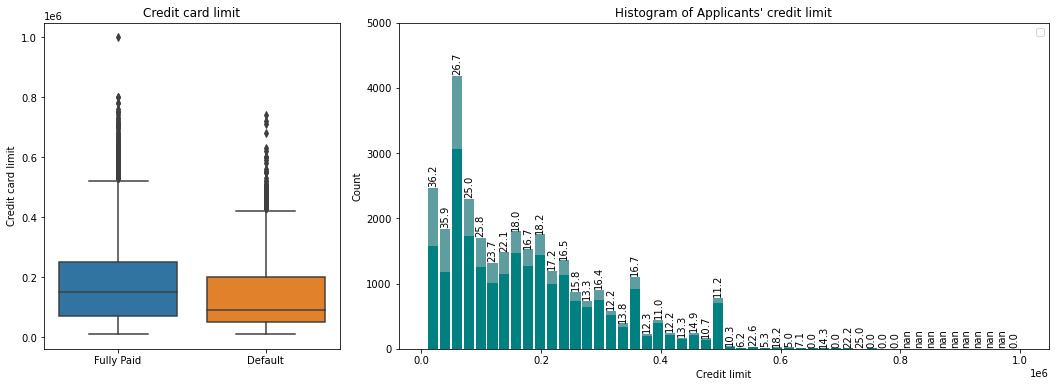

In [90]:
fig = plt.figure(figsize = (18,6))
ax1 = plt.subplot2grid((1,3),(0,0))
ax2 = plt.subplot2grid((1,3),(0,1), colspan=2)

sns.boxplot(y='LIMIT_BAL', x='dpnm', data=df, ax = ax1)
ax1.set_xlabel('')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['Fully Paid','Default'], ha='center')
ax1.set_title('Credit card limit')
ax1.set_ylabel('Credit card limit')

s1 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'LIMIT_BAL'], 'Default': df.loc[df['dpnm']==1, 'LIMIT_BAL']}, index=None)
ax2.hist(s1, stacked=True, bins=50, rwidth=0.85, color=['teal', "cadetblue"]);
ax2.set_title("Histogram of Applicants' credit limit")
ax2.set_xlabel('Credit limit')
ax2.set_ylabel('Count')
ax2.set_ylim(0,5000)
ax2.legend()
    
p = ax2.patches
for i in range(0,50,1):
    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1 + .05
    Y1 = p[i].get_height()
    Y2 = p[i+50].get_height()
    y = Y2 + Y1 + 50
    a = Y2/(Y2 + Y1)
    ax2.text(x, y, round(a*100,1), rotation=90)

In [110]:
s1.index

Int64Index([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')

In [113]:
df['PAY_1'].replace([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['No consumption', 'Paid in full', 'Use of revolving credit', 
                                                             'Delay for one month','Delay for two months',
                                                             'Delay for three months', 'Delay for four months', 
                                                             'Delay for five months', 'Delay for six months',
                                                             'Delay for seven months', 'Delay for eight months', 
                                                             'Delay for nine months and above'], inplace=True)
df['PAY_2'].replace([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['No consumption', 'Paid in full', 'Use of revolving credit', 
                                                             'Delay for one month','Delay for two months',
                                                             'Delay for three months', 'Delay for four months', 
                                                             'Delay for five months', 'Delay for six months',
                                                             'Delay for seven months', 'Delay for eight months', 
                                                             'Delay for nine months and above'], inplace=True)
df['PAY_3'].replace([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['No consumption', 'Paid in full', 'Use of revolving credit', 
                                                             'Delay for one month','Delay for two months',
                                                             'Delay for three months', 'Delay for four months', 
                                                             'Delay for five months', 'Delay for six months',
                                                             'Delay for seven months', 'Delay for eight months', 
                                                             'Delay for nine months and above'], inplace=True)
df['PAY_4'].replace([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['No consumption', 'Paid in full', 'Use of revolving credit', 
                                                             'Delay for one month','Delay for two months',
                                                             'Delay for three months', 'Delay for four months', 
                                                             'Delay for five months', 'Delay for six months',
                                                             'Delay for seven months', 'Delay for eight months', 
                                                             'Delay for nine months and above'], inplace=True)
df['PAY_5'].replace([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['No consumption', 'Paid in full', 'Use of revolving credit', 
                                                             'Delay for one month','Delay for two months',
                                                             'Delay for three months', 'Delay for four months', 
                                                             'Delay for five months', 'Delay for six months',
                                                             'Delay for seven months', 'Delay for eight months', 
                                                             'Delay for nine months and above'], inplace=True)
df['PAY_6'].replace([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['No consumption', 'Paid in full', 'Use of revolving credit', 
                                                             'Delay for one month','Delay for two months',
                                                             'Delay for three months', 'Delay for four months', 
                                                             'Delay for five months', 'Delay for six months',
                                                             'Delay for seven months', 'Delay for eight months', 
                                                             'Delay for nine months and above'], inplace=True)


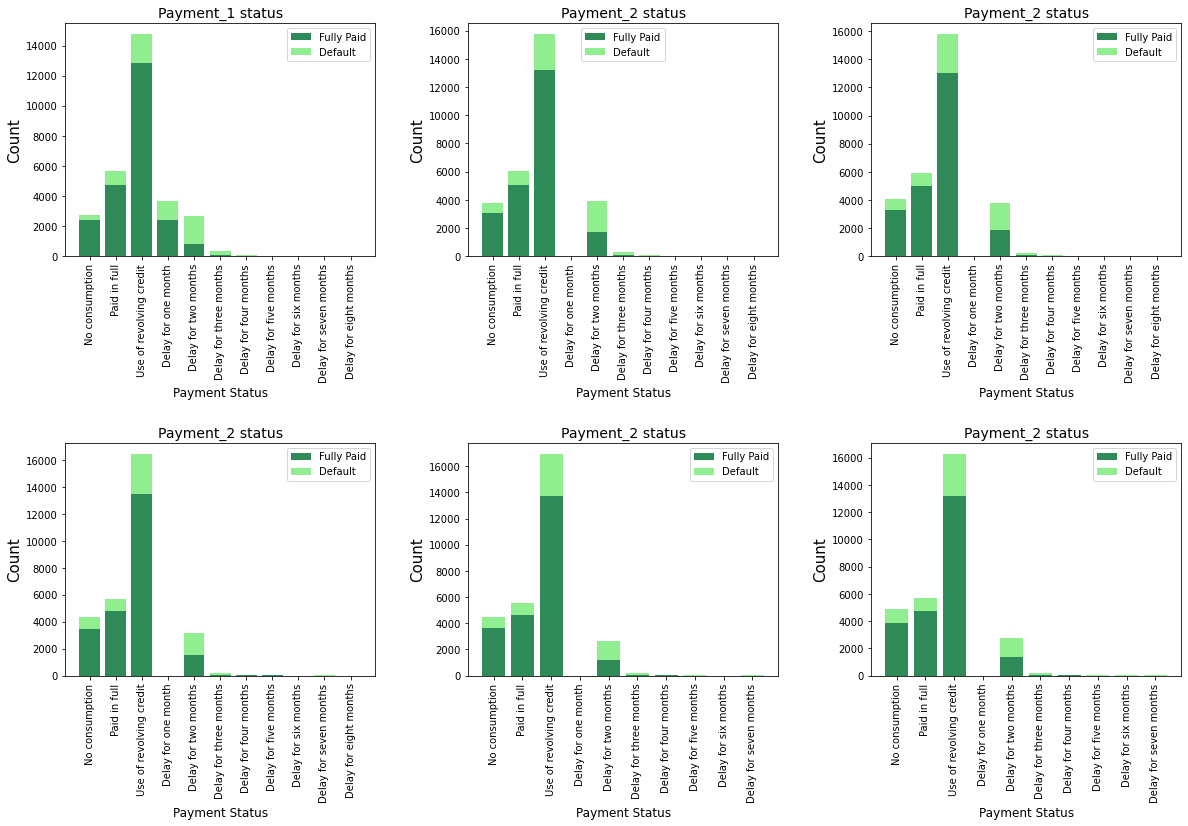

In [137]:
fig, [(ax1, ax2, ax3), (ax4, ax5, ax6)] = plt.subplots(nrows=2, ncols=3, figsize=(20,12))
s1 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'PAY_1'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'PAY_1'].value_counts()}, index=None)
s1 = s1.reindex(['No consumption', 'Paid in full', 'Use of revolving credit','Delay for one month','Delay for two months',
                 'Delay for three months', 'Delay for four months','Delay for five months', 'Delay for six months',
                 'Delay for seven months', 'Delay for eight months'])
s2 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'PAY_2'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'PAY_2'].value_counts()}, index=None)
s3= pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'PAY_3'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'PAY_3'].value_counts()}, index=None)
s4 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'PAY_4'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'PAY_4'].value_counts()}, index=None)
s5 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'PAY_5'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'PAY_5'].value_counts()}, index=None)
s6 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'PAY_6'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'PAY_6'].value_counts()}, index=None)

s2 = s2.reindex(['No consumption', 'Paid in full', 'Use of revolving credit','Delay for one month','Delay for two months',
                 'Delay for three months', 'Delay for four months','Delay for five months', 'Delay for six months',
                 'Delay for seven months', 'Delay for eight months'])

s3 = s3.reindex(['No consumption', 'Paid in full', 'Use of revolving credit','Delay for one month','Delay for two months',
                 'Delay for three months', 'Delay for four months','Delay for five months', 'Delay for six months',
                 'Delay for seven months', 'Delay for eight months'])

s4 = s4.reindex(['No consumption', 'Paid in full', 'Use of revolving credit','Delay for one month','Delay for two months',
                 'Delay for three months', 'Delay for four months','Delay for five months', 'Delay for six months',
                 'Delay for seven months', 'Delay for eight months'])

s5 = s5.reindex(['No consumption', 'Paid in full', 'Use of revolving credit','Delay for one month','Delay for two months',
                 'Delay for three months', 'Delay for four months','Delay for five months', 'Delay for six months',
                 'Delay for seven months', 'Delay for eight months'])

s6 = s6.reindex(['No consumption', 'Paid in full', 'Use of revolving credit','Delay for one month','Delay for two months',
                 'Delay for three months', 'Delay for four months','Delay for five months', 'Delay for six months',
                 'Delay for seven months', 'Delay for eight months'])

ax1.bar(s1.index, s1['Fully Paid'], color='seagreen')
ax1.bar(s1.index, s1['Default'], bottom=s1['Fully Paid'], color='lightgreen')
ax1.set_xticklabels(s1.index, rotation=90)
ax1.legend(['Fully Paid', 'Default'])
ax1.set_xlabel('Payment Status', fontsize=12)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_title("Payment_1 status", fontsize=14)

ax2.bar(s2.index, s2['Fully Paid'], color='seagreen')
ax2.bar(s2.index, s2['Default'], bottom=s2['Fully Paid'], color='lightgreen')
ax2.set_xticklabels(s1.index, rotation=90)
ax2.legend(['Fully Paid', 'Default'])
ax2.set_xlabel('Payment Status', fontsize=12)
ax2.set_ylabel('Count', fontsize=15)
ax2.set_title("Payment_2 status", fontsize=14)

ax3.bar(s3.index, s3['Fully Paid'], color='seagreen')
ax3.bar(s3.index, s3['Default'], bottom=s3['Fully Paid'], color='lightgreen')
ax3.set_xticklabels(s1.index, rotation=90)
ax3.legend(['Fully Paid', 'Default'])
ax3.set_xlabel('Payment Status', fontsize=12)
ax3.set_ylabel('Count', fontsize=15)
ax3.set_title("Payment_2 status", fontsize=14)

ax4.bar(s4.index, s4['Fully Paid'], color='seagreen')
ax4.bar(s4.index, s4['Default'], bottom=s4['Fully Paid'], color='lightgreen')
ax4.set_xticklabels(s1.index, rotation=90)
ax4.legend(['Fully Paid', 'Default'])
ax4.set_xlabel('Payment Status', fontsize=12)
ax4.set_ylabel('Count', fontsize=15)
ax4.set_title("Payment_2 status", fontsize=14)


ax5.bar(s5.index, s5['Fully Paid'], color='seagreen')
ax5.bar(s5.index, s5['Default'], bottom=s5['Fully Paid'], color='lightgreen')
ax5.set_xticklabels(s1.index, rotation=90)
ax5.legend(['Fully Paid', 'Default'])
ax5.set_xlabel('Payment Status', fontsize=12)
ax5.set_ylabel('Count', fontsize=15)
ax5.set_title("Payment_2 status", fontsize=14)

ax6.bar(s6.index, s6['Fully Paid'], color='seagreen')
ax6.bar(s6.index, s6['Default'], bottom=s6['Fully Paid'], color='lightgreen')
ax6.set_xticklabels(s6.index, rotation=90)
ax6.legend(['Fully Paid', 'Default'])
ax6.set_xlabel('Payment Status', fontsize=12)
ax6.set_ylabel('Count', fontsize=15)
ax6.set_title("Payment_2 status", fontsize=14)
plt.subplots_adjust(hspace=0.8, wspace=.3);
plt.show()

array([[<AxesSubplot:title={'center':'PAY_1'}>,
        <AxesSubplot:title={'center':'PAY_2'}>,
        <AxesSubplot:title={'center':'PAY_3'}>,
        <AxesSubplot:title={'center':'PAY_4'}>],
       [<AxesSubplot:title={'center':'PAY_5'}>,
        <AxesSubplot:title={'center':'PAY_6'}>,
        <AxesSubplot:title={'center':'BILL_AMT1'}>,
        <AxesSubplot:title={'center':'BILL_AMT2'}>],
       [<AxesSubplot:title={'center':'BILL_AMT3'}>,
        <AxesSubplot:title={'center':'BILL_AMT4'}>,
        <AxesSubplot:title={'center':'BILL_AMT5'}>,
        <AxesSubplot:title={'center':'BILL_AMT6'}>],
       [<AxesSubplot:title={'center':'PAY_AMT1'}>,
        <AxesSubplot:title={'center':'PAY_AMT2'}>,
        <AxesSubplot:title={'center':'PAY_AMT3'}>,
        <AxesSubplot:title={'center':'PAY_AMT4'}>],
       [<AxesSubplot:title={'center':'PAY_AMT5'}>,
        <AxesSubplot:title={'center':'PAY_AMT6'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

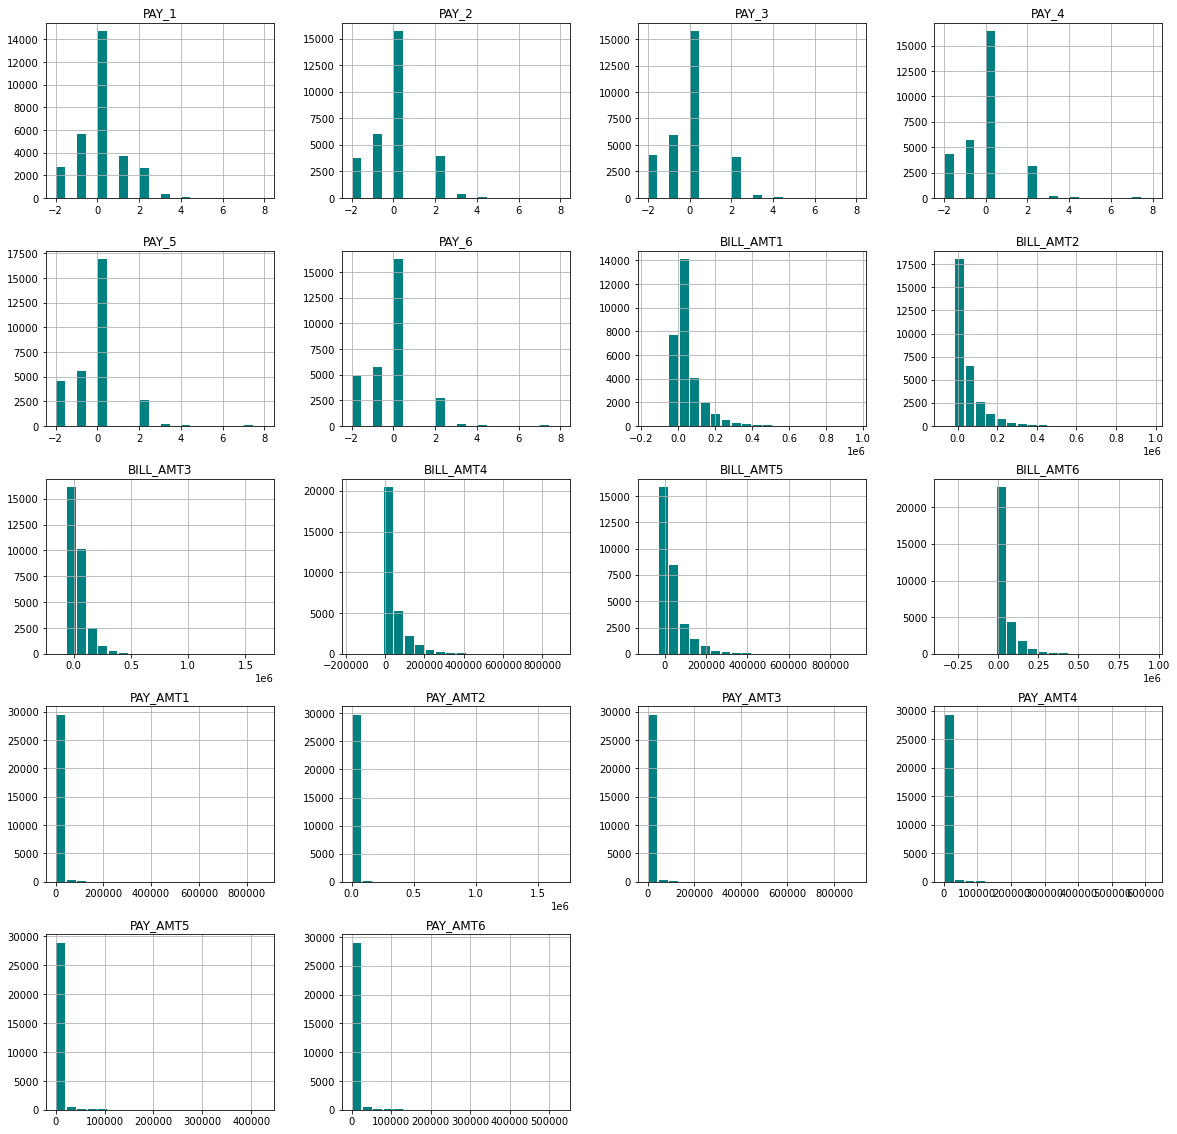

In [94]:
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].hist(bins=20, rwidth=0.85, color=["teal"], figsize=(20,20))